# Investigación y preparación de datos: 

---

## 1) `torch.nn.RNN` (PyTorch)

**i. Input esperado**

- Forma por defecto: `x.shape = (seq_len, batch, input_size)`.
- Si `batch_first=True`: `x.shape = (batch, seq_len, input_size)`.
- Estado oculto inicial (opcional) `h0.shape = (num_layers * num_directions, batch, hidden_size)`.
- Puedes pasar también un `PackedSequence` (via `torch.nn.utils.rnn.pack_padded_sequence`) para manejar longitudes variables.

**ii. Output que devuelve**

- `output`: todas las salidas por *time-step* de la **última** capa.
  - Por defecto: `output.shape = (seq_len, batch, num_directions * hidden_size)`.
  - Con `batch_first=True`: `output.shape = (batch, seq_len, num_directions * hidden_size)`.
- `hn`: estado oculto final **por capa y dirección**  
  `hn.shape = (num_layers * num_directions, batch, hidden_size)`.

> **Nota**  
> - `num_directions = 2` si `bidirectional=True`, en otro caso `= 1`.  
> - Si usas `PackedSequence`, `output` será `PackedSequence` y `hn` conserva su forma estándar.

**iii. Parámetros de configuración importantes**

- `input_size`: dimensión de la característica de entrada por *time-step*.
- `hidden_size`: tamaño del estado oculto por dirección.
- `num_layers` (def. `1`): apila múltiples capas RNN.
- `nonlinearity` (solo `RNN`): `'tanh'` (defecto) o `'relu'`.
- `bias` (def. `True`): incluye sesgos en las proyecciones.
- `batch_first` (def. `False`): si `True`, el batch va primero.
- `dropout` (def. `0.0`): *dropout* aplicado entre capas (si `num_layers > 1`).
- `bidirectional` (def. `False`): activa una RNN bidireccional (adelante y atrás).

---

## 2) Dataset **Sunspots**

**i. ¿Qué mide?**  
Cuenta (o índice) de manchas solares observadas en la superficie del Sol. Es un *proxy* de la actividad solar.

**ii. ¿Cuál es el rango temporal de los datos?**  
Depende de la fuente/versionado:
- **Serie anual** clásica (incluida en `statsmodels.datasets.sunspots`): ~**1700–2008** (anual).
- **Serie mensual** del SILSO/NOAA: **1749–presente** (mensual; suele actualizarse periódicamente).  
Para ejercicios reproducibles offline, la versión anual de `statsmodels` es práctica.

**iii. ¿Por qué es útil para predecir series temporales?**  
- Presenta **ciclos cuasi-periódicos** (~11 años) → patrón útil para modelos secuenciales.  
- Incluye **tendencias/variaciones** de amplitud y ruidos realistas → buen *benchmark* para RNN/LSTM/Transformers.  
- Es **univariada** y de **baja dimensionalidad**, ideal para demostrar *pipelines* de predicción.




,sunspots
date,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


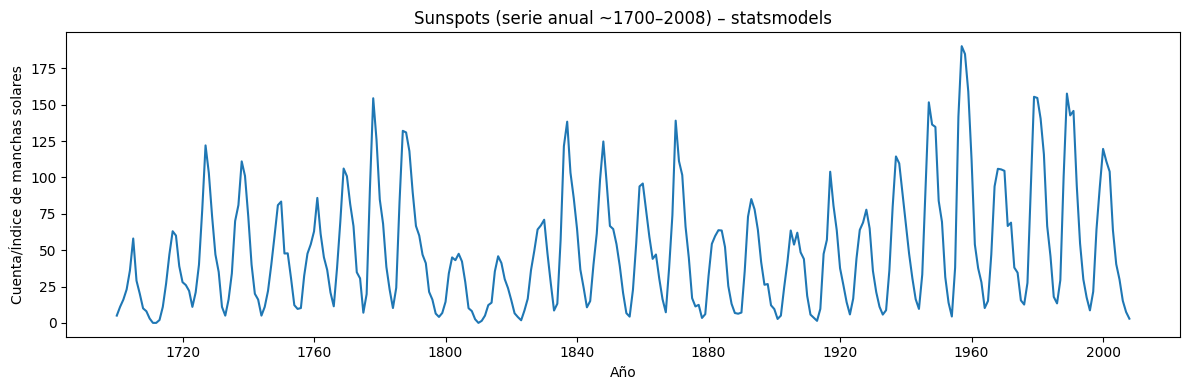

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import sunspots as sm_sunspots

# Cargar a DataFrame
data = sm_sunspots.load_pandas().data  # columnas típicas: YEAR, SUNACTIVITY
df = pd.DataFrame({
    "date": pd.to_datetime(data["YEAR"], format="%Y"),
    "sunspots": data["SUNACTIVITY"].astype(float)
}).set_index("date")

display(df.head())  # primeras filas

# Visualización de la serie completa (anual)
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["sunspots"])
plt.title("Sunspots (serie anual ~1700–2008) – statsmodels")
plt.xlabel("Año")
plt.ylabel("Cuenta/Índice de manchas solares")
plt.tight_layout()
plt.show()

,sunspots,sunspots_norm
date,,
1700-01-01,5.0,-0.947424
1701-01-01,11.0,-0.884332
1702-01-01,16.0,-0.831756
1703-01-01,23.0,-0.758149
1704-01-01,36.0,-0.621451


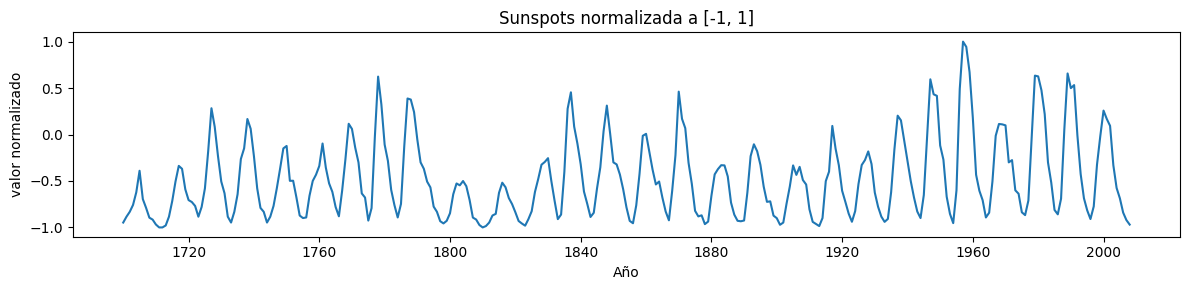

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

df["sunspots_norm"] = scaler.fit_transform(df[["sunspots"]])  # ajusta y transforma columna
display(df.head())

# Visualizar normalizada
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.plot(df.index, df["sunspots_norm"])
plt.title("Sunspots normalizada a [-1, 1]")
plt.xlabel("Año")
plt.ylabel("valor normalizado")
plt.tight_layout()
plt.show()
